### This is a proof of concept for random forest

In [28]:
# load all packages

import numpy as np                      
import os                               # to work with filepaths and local directories
import matplotlib.pyplot as plt         # to display the output images in the notebook
%matplotlib inline

# Python image library (PIL) lets you access .tiff files
from PIL import Image

# to create and add functionality to a widget
import ipywidgets as widgets

# to display the widget
from IPython.display import display

# to save arrays to .tiff files
import imageio
# to check your OS in order to open a file saving prompt
import platform
import tempfile
import shutil
from tkinter import Tk, filedialog
from skimage import io, color

<class 'numpy.ndarray'>
(695, 1152, 3)
<PIL.TiffImagePlugin.TiffImageFile image mode=RGB size=1152x695 at 0x1B8E28F2FD0>


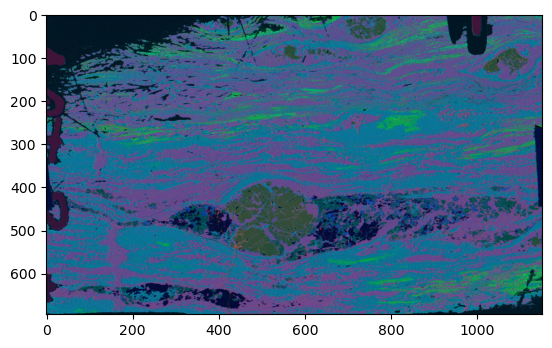

In [29]:
# Load in a single image
RGB_1 = Image.open('/Users/U/Documents/ESS469/Petro-Pixel-Poppers/ML-Geo-23/Aikin Data/78.7-10-1_Hot/RGB/78.7-10-1_Hot_MineralMasks-MgAlK.tif')

RGB_1_gray = color.rgb2gray(RGB_1)
# Turn this image into an array
RGB_1_array = np.asarray(RGB_1)
# RGB_1 = np.squeeze(RGB_1)

RGB_1_gray_array = np.asarray(RGB_1_gray)


print(type(RGB_1_array))
print(RGB_1_array.shape)
print(RGB_1)

plt.imshow(RGB_1)
# plt.show(RGB_1)

(695, 1152, 3)


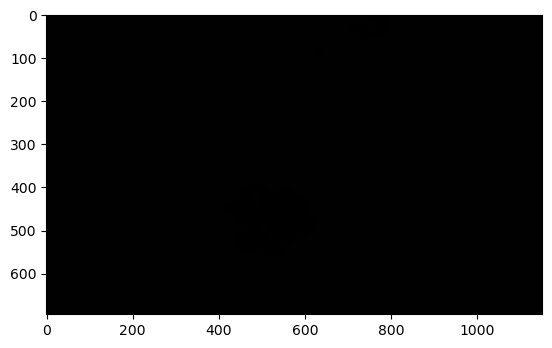

In [94]:
from skimage import io, color, filters
import matplotlib.pyplot as plt
from PIL import Image

# Load the grayscale image
grayscale_image_path = '/Users/U/Documents/ESS469/Petro-Pixel-Poppers/ML-Geo-23/Aikin Data/78.7-10-1_Hot/masks/78.7-10-1_Hot_mask-Garnet.tif'
grayscale_image = Image.open(grayscale_image_path)
# grayscale = io.imread(grayscale_image)
grayscale_image = np.stack((grayscale_image,)*3, axis=-1)
grayscale_array = np.asarray(grayscale_image)

# # Convert the image to a valid data type (float or uint8)
# grayscale_image = grayscale_image.astype(np.float32)  # Adjust the data type if needed

# # Apply thresholding
# threshold_value = filters.threshold_otsu(grayscale_image)
# binary_image = (grayscale_image > threshold_value).astype(np.uint8)

# # Display the original and binary images
# fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# axes[0].imshow(grayscale_image, cmap='gray')
# axes[0].set_title('Original Grayscale Image')

# axes[1].imshow(binary_image, cmap='binary')
# axes[1].set_title('Binary Image')

print(grayscale_array.shape)
plt.imshow(grayscale_image, cmap = 'gray')

In [90]:
RGB_1 = RGB_1_array.flatten()
RGB_1_gray = RGB_1_gray_array.flatten()
# binary_image = binary_image.flatten()
grayscale_image = grayscale_array.flatten()

print(RGB_1.shape)
# print(binary_image)
print(RGB_1_gray.shape)
print(grayscale_image.shape)

(2401920,)
(800640,)
(800640,)


In [52]:
import pandas as pd

#Creating a pandas dataframe from all the arrays. T is used to transpose the dataframe
df = pd.DataFrame(data=[RGB_1_gray, grayscale_image]).T

#Assigning the column names to each feature
df.columns=['RGB','Mineral']

#Checking to see if it worked
print(df.head(5))
print(df['Mineral'].describe())

        RGB  Mineral
0  0.069927      1.0
1  0.078359      1.0
2  0.062635      1.0
3  0.096032      1.0
4  0.085629      1.0
count    2.401920e+06
mean     9.748027e-01
std      1.567241e-01
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: Mineral, dtype: float64


In [54]:
#Assigning the correct data types to each feature
df.RGB=df['RGB'].astype(float)
df.Mineral=df['Mineral'].astype(str)

print(df.dtypes)

RGB        float64
Mineral     object
dtype: object


In [58]:
#Creating a subset dataframe where the area of interest value is known
df_model=df.dropna()

#Checking our new data
print(df_model.describe())

                 RGB
count  800640.000000
mean        0.325613
std         0.096831
min         0.008416
25%         0.315917
50%         0.349644
75%         0.380035
max         0.742318


In [59]:
X = np.array(df_model['RGB']).reshape(-1,1)
y = np.array(df_model['Mineral'])
print(X)
print(y)

[[0.06992745]
 [0.07835882]
 [0.0626349 ]
 ...
 [0.08734078]
 [0.0747051 ]
 [0.07579922]]
['1.0' '1.0' '1.0' ... '1.0' '1.0' '1.0']


In [60]:
#Importing the train/test and scaling modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#Splitting the data 75/25% into training and test data and then scaling the features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

#Scaling our features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [61]:
#Importing the random forest classifier and grid search module
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#Creating our inital test classifier
RF = RandomForestClassifier()

#Selecting our algorithm variables that will be tested on our dataset and running them through a grid search
grid_param_RF = { 'n_estimators': [50, 100], 'criterion': ['gini', 'entropy'], 'bootstrap': [True, False]}
gd_sr_RF = GridSearchCV(estimator=RF, param_grid=grid_param_RF, scoring='accuracy',cv=10, n_jobs=-1)
gd_sr_RF.fit(X_train, y_train)

#Assigning a variable to the best paramaters and the classification accuracy
best_parameters_RF = gd_sr_RF.best_params_
best_result_RF = gd_sr_RF.best_score_

print(best_parameters_RF)
print(best_result_RF)

{'bootstrap': True, 'criterion': 'gini', 'n_estimators': 100}
0.9905109245936584


In [62]:
#Creating a new model with the desired parameters
model = RandomForestClassifier(bootstrap=True, criterion= 'gini', n_estimators= 100)

#Fitting the model to the training data
model.fit(X_train, y_train)

#Printing all the model parameters
print(model)

RandomForestClassifier()


In [65]:
#Splitting the inital dataframe 
y_new = np.array(df_model.pop('Mineral').values)
X_new = np.array(df_model)

#Scaling it to match the model input
X_new = scaler.fit_transform(X_new)

In [66]:
#Creating numpy arrays of the classification (prediction) data and the probablity that each value either satisfies 
#Garnet=1
y_pred = model.predict(X_new)
y_prob = model.predict_proba(X_new)

print(y_pred.shape, y_prob.shape)

(800640,) (800640, 2)


In [67]:
#Splitting the y_prob array into two seperate 1 dimensional arrays
y_prob_split = np.split(y_prob, 2, axis=1)

y_prob_1 = y_prob_split[0]
y_prob_2 = y_prob_split[1]

print(y_prob_1.shape)

(800640, 1)


In [68]:
#Reshaping the 1d arrays to be representable as an image
y_pred = y_pred.reshape(695, 1152).astype(float)
y_prob_1 = y_prob_1.reshape(695, 1152)
y_prob_2 = y_prob_2.reshape(695, 1152)

In [72]:
#Importing rasterio 
import rasterio as rio

#Accessing the metadata of the existing 'Geology' image
with rio.open('/Users/U/Documents/ESS469/Petro-Pixel-Poppers/ML-Geo-23/Aikin Data/78.7-10-2_Hot/78.7-10-2_Hot_FeKCa.Tiff') as src:
    study_area_ras = src.read()
    study_area_meta = src.profile

print(study_area_meta)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1152, 'height': 695, 'count': 3, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'blockysize': 695, 'tiled': False, 'interleave': 'band'}


C:\Users\U\AppData\Roaming\Python\Python311\site-packages\rasterio\__init__.py:317: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [73]:
#Viewing the transform and crs
study_area_transform = study_area_meta["transform"]
study_area_crs = study_area_meta["crs"]

print(study_area_transform)
print(study_area_crs)

| 1.00, 0.00, 0.00|
| 0.00, 1.00, 0.00|
| 0.00, 0.00, 1.00|
None


In [74]:
#Ensuring the count value is 1 (1 band of pixel data) and assigning the data as float to be compatible with the 
#new data
study_area_meta['count'] = 1
study_area_meta['dtype'] = "float64"

print(study_area_meta)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 1152, 'height': 695, 'count': 1, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'blockysize': 695, 'tiled': False, 'interleave': 'band'}


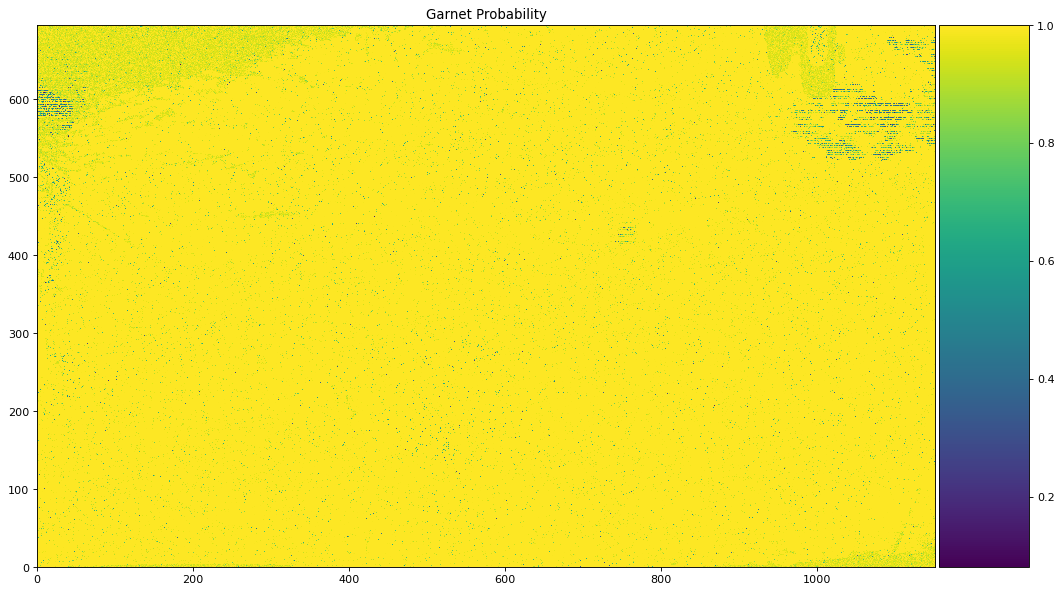

In [75]:
#Importing required packages
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pylab import *

#Setting the image size
plt.figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')

#Setting the eastings and northings boundary
bounds = [0, 1152, 0, 695]

#Loading the image data and setting extents
plt.title('Garnet Probability')
ax = plt.gca()
im = ax.imshow(y_prob_2, interpolation='nearest', extent=bounds)

#Plotting colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.05)
plt.colorbar(im, cax=cax)

#Visualising the image
plt.show()